# Week 4 - Univariate Analysis, part 2

# 1. Lesson - None

# 2. Weekly graph question

Below are a histogram and boxplot representation of the same data. A pharmacy is keeping a record of the prices of the drugs that it sells, and an administrator wants to know how much the more expensive drugs tend to cost, in the context of the other prices.

Please write a short explanation of the pros and cons of these two representations. Which would you choose? How would you modify the formatting, if at all, to make it more visually interesting, clear, or informative?

In [9]:
import numpy as np
import pandas as pd

np.random.seed(0)
num_data = 100
data = np.exp(np.random.uniform(size = num_data) * 4)
df = pd.DataFrame(data.T, columns = ["data"])

The 75th percentile is: data    15.457656
Name: 0.75, dtype: float64


<Axes: ylabel='Frequency'>

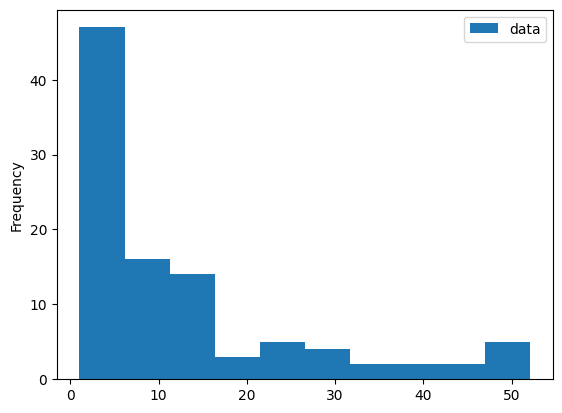

In [10]:
print("The 75th percentile is:", df.quantile(q = 0.75))
df.plot.hist()

<Axes: >

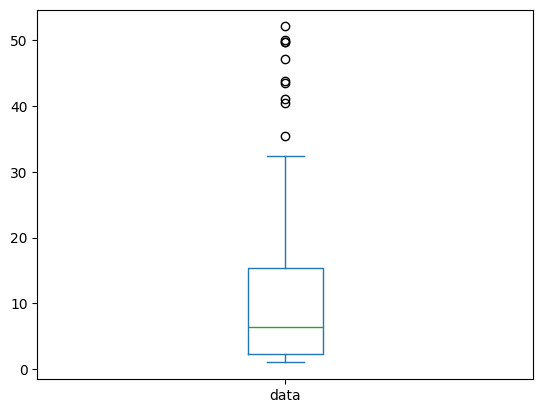

In [11]:
df.plot.box()

In [12]:
# When looking at the histogram and box plot for the drug prices, each offers something a bit different.
#
# The histogram gives a clear sense of how the prices are distributed. It’s helpful for spotting where most of the prices fall
# and whether there are any patterns, like clusters or a long tail of higher prices. The main catch is that the appearance of the
# histogram depends a lot on how the bins are set. If the bins are too wide, important details can get lost, but if they’re too narrow,
# the plot can look cluttered. Outliers aren’t always easy to see with a histogram, either.
#
# The box plot, on the other hand, provides a quick summary of the data. It shows the median, overall spread, and any outliers right away.
# That makes it useful when you need a high-level overview without getting bogged down in details. The trade-off is that it doesn’t show
# how values are distributed within the quartiles, and if someone isn’t familiar with how to read a box plot, it might not be as intuitive.
#
# Between the two, I’d lean toward using the box plot because it’s faster to interpret when looking for overall trends and outliers.
# Still, using both together gives a more complete picture: the histogram shows the finer details of how prices are distributed,
# while the box plot provides a concise summary of key statistics.
#
# If I were to improve the visuals, I’d make sure the histogram uses an appropriate bin size—something balanced so details aren’t lost
# or overemphasized. Adding subtle color gradients could help highlight frequency differences. For the box plot, making the outliers
# stand out more or adding notches to show confidence intervals could make the information clearer.
#
# In the end, combining both plots seems like the best approach. It allows you to understand both the overall structure and the detailed
# distribution of the data, which is important when analyzing something like price variability.

# 3. Homework - working on your datasets

This week, you will do the same types of exercises as last week, but you should use your own datasets that you found last semester.

### Here are some types of analysis you can do:

- Draw histograms and histogram variants for each feature or column.  (Swarm plot, kde plot, violin plot).

- Draw grouped histograms.  For instance, if you have tree heights for both maple and oak trees, you could draw histograms for both.

- Draw a bar plot to indicate total counts of each categorical variable in a given column.

- Find means, medians, and modes.

### Conclusions:

- Explain what conclusions you would draw from this analysis: are the data what you expect?  Are the data likely to be usable?  If they are not useable, find some new data!

- What is the overall shape of the distribution?  Is it normal, skewed, bimodal, uniform, etc.?

- Are there any outliers present?  (Data points that are far from the others.)

- If there are multiple related histograms, how does the distribution change across different groups?

- What are the minimum and maximum values represented in each histogram?

- How do bin sizes affect the histogram?  Does changing the bin width reveal different patterns in the data?

- Does the distribution appear normal, or does it have a different distribution?

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
import random
import io
from datetime import datetime, timedelta

In [15]:
# Searching for and moving the Kaggle API Certificate
import os
import shutil


def find_file(filename, search_path='.'):
    # Search for a file within a directory tree
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            return os.path.join(root, filename)
    return None

# Search for kaggle.json starting from the root directory
file_to_search = 'kaggle.json'
result = find_file(file_to_search, search_path='/')

if result:
    print("Found '{}' at: {}".format(file_to_search, result))
else:
    print("'{}' not found.".format(file_to_search))

source = '/home/codespace/.kaggle/kaggle.json'
destination_dir = os.path.expanduser('~/.kaggle')
destination = os.path.join(destination_dir, 'kaggle.json')

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Move the file
shutil.move(source, destination)
print("Moved kaggle.json to ~/.kaggle/")

Found 'kaggle.json' at: /home/codespace/.kaggle/kaggle.json
Moved kaggle.json to ~/.kaggle/


In [8]:
import os
import shutil
import pandas as pd
import numpy as np
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import gc

# ------------------------------- Setup & Cleanup -------------------------------- #

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Output directory
output_dir = "Data_Analysis_Results"

# Delete existing results directory if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    logging.info(f"Deleted old output directory: {output_dir}")

# Recreate output directory
os.makedirs(output_dir, exist_ok=True)
logging.info(f"Created fresh output directory: {output_dir}")

# ------------------------- Utility Functions ----------------------------------- #

def memory_reduce(df):
    """Downcast numeric columns to reduce memory usage."""
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

def load_csv_efficiently(file_path):
    """Load CSV in chunks and concatenate for efficiency."""
    chunk_list = []
    try:
        for chunk in pd.read_csv(file_path, chunksize=50000):
            chunk = memory_reduce(chunk)
            chunk_list.append(chunk)
        return pd.concat(chunk_list, ignore_index=True)
    except Exception as e:
        logging.error(f"Error loading {file_path}: {e}")
        return pd.DataFrame()

# ------------------------- Analysis Functions ----------------------------------- #

def analyze_missing_and_empty_values(df):
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    empty_strings = (df == '').sum()
    whitespace_only_strings = df.apply(lambda col: col.astype(str).str.strip().eq('').sum())
    return missing_values, missing_percent, empty_strings, whitespace_only_strings

def plot_feature_histograms(df, dataset_output_dir, dataset_name):
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.empty:
        return "No numerical columns to plot.\n"

    plot_path = os.path.join(dataset_output_dir, f"{dataset_name}_feature_histograms.png")
    numeric_cols.sample(frac=0.5, random_state=42).hist(figsize=(12, 10), bins=20)
    plt.suptitle(f"Feature Histograms: {dataset_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(plot_path, dpi=100)
    plt.close()
    gc.collect()
    return f"Feature histograms saved to {plot_path}\n"

def plot_correlation_matrix(df, dataset_output_dir, dataset_name):
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.empty:
        return "No numerical columns for correlation analysis.\n"

    sample_df = numeric_cols.sample(frac=0.3, random_state=42) if len(numeric_cols) > 1000 else numeric_cols
    correlation_matrix = sample_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
    correlation_plot_path = os.path.join(dataset_output_dir, f"{dataset_name}_correlation_matrix.png")
    plt.savefig(correlation_plot_path, dpi=100)
    plt.close()
    gc.collect()
    return f"Correlation matrix saved to {correlation_plot_path}\n"

def plot_feature_importance(df, dataset_output_dir, dataset_name):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) < 2:
        return "Insufficient numerical features for feature importance.\n"

    df_clean = df[numeric_cols].dropna()
    if df_clean.shape[0] > 5000:
        df_clean = df_clean.sample(n=5000, random_state=42)

    X = df_clean.drop(columns=[numeric_cols[0]])
    y = df_clean[numeric_cols[0]]

    model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
    model.fit(X, y)
    feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    importance_plot_path = os.path.join(dataset_output_dir, f"{dataset_name}_feature_importance.png")
    feature_importance.plot(kind='barh', figsize=(10, 6))
    plt.title(f"Feature Importance: {dataset_name}")
    plt.savefig(importance_plot_path, dpi=100)
    plt.close()
    gc.collect()
    return f"Feature importance saved to {importance_plot_path}\n"

# ------------------------- Main Analysis Loop ----------------------------------- #

def analyze_csv(file_path, project_output_dir):
    dataset_name = os.path.splitext(os.path.basename(file_path))[0]
    dataset_output_dir = os.path.join(project_output_dir, dataset_name)
    os.makedirs(dataset_output_dir, exist_ok=True)
    report_path = os.path.join(dataset_output_dir, f"{dataset_name}_report.txt")

    df = load_csv_efficiently(file_path)
    if df.empty:
        logging.warning(f"Skipping {dataset_name} due to loading issues.")
        return

    with open(report_path, "w") as report:
        report.write(f"Analysis Report: {dataset_name}\n{'='*40}\n")
        report.write("Summary Statistics:\n" + df.describe(include='all').to_string() + "\n\n")

        missing_values, missing_percent, empty_strings, whitespace_only_strings = analyze_missing_and_empty_values(df)
        report.write("Missing Values:\n" + missing_percent.to_string() + "\n\n")
        report.write("Empty Strings:\n" + empty_strings.to_string() + "\n\n")
        report.write("Whitespace Only Strings:\n" + whitespace_only_strings.to_string() + "\n\n")

        report.write(plot_correlation_matrix(df, dataset_output_dir, dataset_name))
        report.write(plot_feature_histograms(df, dataset_output_dir, dataset_name))
        report.write(plot_feature_importance(df, dataset_output_dir, dataset_name))

    del df
    gc.collect()

def analyze_all_csvs(base_directory):
    for folder in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, folder)
        if os.path.isdir(folder_path):
            output_folder = os.path.join(output_dir, folder)
            os.makedirs(output_folder, exist_ok=True)
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".csv"):
                        analyze_csv(os.path.join(root, file), output_folder)

# ------------------------------ Run Analysis ----------------------------------- #

datasets_directory = "."  
analyze_all_csvs(datasets_directory)
logging.info("All datasets processed successfully.")

2025-02-22 06:59:12,885 - INFO - Deleted old output directory: Data_Analysis_Results
2025-02-22 06:59:12,890 - INFO - Created fresh output directory: Data_Analysis_Results
2025-02-22 06:59:12,902 - ERROR - Error loading ./GlobalRenewEnergyProd_2000_2022/IRENA_RenewableEnergy_Statistics_2000-2022.csv: 'utf-8' codec can't decode byte 0xf4 in position 229733: invalid continuation byte
2025-02-22 06:59:12,904 - WARNING - Skipping IRENA_RenewableEnergy_Statistics_2000-2022 due to loading issues.
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x76d67a34bd70>>
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
2025-02-22 06:59:42,253 - INFO - All datasets processed successfully.


In [ ]:
# Data Story: Evolution of Modern Renewable Energy

# Who:
# - Policymakers and energy planners
# - Environmental researchers and advocates
# - Renewable energy investors and developers

# What:
# - Analyze the growth trajectory of renewable energy from 1971 to the present
# - Identify key milestones and trends in renewable energy adoption
# - Assess regional contributions to global renewable energy capacity

# How:
# - Utilize time-series analysis to track changes in renewable energy production
# - Create visualizations like line charts to depict growth over decades
# - Develop regional maps highlighting areas with significant renewable energy investments

# Data Story: Global Renewable Energy Production

# Who:
# - International energy agencies and organizations
# - Climate change researchers
# - Policy analysts focusing on global energy transitions

# What:
# - Examine global renewable energy production patterns from 2000 to 2022
# - Compare renewable energy outputs across different countries and regions
# - Evaluate the impact of policy changes on renewable energy growth

# How:
# - Employ comparative analysis to benchmark countries' renewable energy outputs
# - Use bar charts and heatmaps to visualize production levels and growth rates
# - Analyze policy timelines alongside production data to identify correlations

# Data Story: US Energy Generation

# Who:
# - US federal and state energy regulators
# - Energy market analysts
# - Environmental policy advocates

# What:
# - Investigate energy generation trends in the US from 2001 to 2022
# - Assess the shift from fossil fuels to renewable energy sources
# - Identify state-level variations in energy generation mixes

# How:
# - Perform trend analysis to observe shifts in energy source contributions over time
# - Create stacked area charts to illustrate changes in the energy mix
# - Develop state-by-state comparison maps to highlight regional differences

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import gc

# ------------------------------- Setup & Cleanup -------------------------------- #

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Output directory
output_dir = "Data_Analysis_Results"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    logging.info(f"Deleted old output directory: {output_dir}")
os.makedirs(output_dir, exist_ok=True)
logging.info(f"Created fresh output directory: {output_dir}")

# --------------------------- Memory Management Functions ------------------------ #

def reduce_memory_usage(df):
    """Downcasts numeric columns to reduce memory usage."""
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtype
        if pd.api.types.is_numeric_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif pd.api.types.is_object_dtype(col_type):
            num_unique = df[col].nunique()
            num_total = len(df[col])
            if num_unique / num_total < 0.5:
                df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    logging.info(f"Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB")
    return df

# ------------------------- Analysis Functions ----------------------------------- #

def analyze_missing_and_empty_values(df):
    """Analyzes missing, empty, and whitespace-only strings."""
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    empty_strings = (df == '').sum()
    whitespace_only_strings = df.apply(lambda col: col.apply(lambda x: isinstance(x, str) and x.strip() == '').sum())
    return missing_values, missing_percent, empty_strings, whitespace_only_strings

def plot_feature_histograms(df, dataset_output_dir, dataset_name):
    """Plots histograms for numerical features (skips if too many columns)."""
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.empty or len(numeric_cols.columns) > 30:
        logging.warning(f"Skipping histograms for {dataset_name}: Too many numerical columns.")
        return "Histograms skipped due to column limit.\n"

    plot_path = os.path.join(dataset_output_dir, f"{dataset_name}_feature_histograms.png")
    numeric_cols.hist(figsize=(12, 10), bins=25)
    plt.suptitle(f"Feature Histograms: {dataset_name}", fontsize=14)
    plt.tight_layout()
    plt.savefig(plot_path, dpi=100)
    plt.close()
    logging.info(f"Feature histograms saved: {plot_path}")
    return f"Histograms saved: {plot_path}\n"

def plot_correlation_matrix(df, dataset_output_dir, dataset_name):
    """Plots correlation matrix with a column limit."""
    numeric_cols = df.select_dtypes(include=[np.number])
    if len(numeric_cols.columns) < 2:
        logging.warning(f"Not enough numerical columns for correlation analysis in {dataset_name}")
        return "Correlation matrix skipped.\n"

    correlation_matrix = numeric_cols.corr()
    plot_path = os.path.join(dataset_output_dir, f"{dataset_name}_correlation_matrix.png")

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
    plt.title(f'Correlation Matrix: {dataset_name}')
    plt.savefig(plot_path, dpi=120)
    plt.close()

    logging.info(f"Correlation matrix saved: {plot_path}")
    return f"Correlation matrix saved: {plot_path}\n"

def plot_feature_importance(df, dataset_output_dir, dataset_name):
    """Calculates feature importance using RandomForestRegressor."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) < 2:
        logging.warning(f"Not enough numerical features for feature importance in {dataset_name}")
        return "Feature importance skipped.\n"

    df_clean = df[numeric_cols].dropna()
    if df_clean.empty:
        return "No valid rows for feature importance.\n"

    y = df_clean[numeric_cols[0]]
    X = df_clean.drop(columns=[numeric_cols[0]])

    model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
    model.fit(X, y)
    feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()

    plot_path = os.path.join(dataset_output_dir, f"{dataset_name}_feature_importance.png")
    feature_importance.plot(kind='barh', figsize=(10, 8))
    plt.title(f"Feature Importance: {dataset_name}")
    plt.savefig(plot_path, dpi=120)
    plt.close()

    logging.info(f"Feature importance plot saved: {plot_path}")
    return f"Feature importance plot saved: {plot_path}\n"

# ------------------------- Main Analysis Function ------------------------------- #

def analyze_csv(file_path, project_output_dir):
    """Processes and analyzes a single CSV file."""
    dataset_name = os.path.splitext(os.path.basename(file_path))[0]
    dataset_output_dir = os.path.join(project_output_dir, dataset_name)
    os.makedirs(dataset_output_dir, exist_ok=True)
    report_path = os.path.join(dataset_output_dir, f"{dataset_name}_analysis_report.txt")

    try:
        df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)

    df = reduce_memory_usage(df)

    with open(report_path, "w") as report:
        report.write(f"Analysis Report: {dataset_name}\n{'=' * 50}\n")
        report.write("Data Preview:\n" + df.head().to_string() + "\n\n")
        report.write("Summary Statistics:\n" + df.describe(include='all').to_string() + "\n\n")

        # Missing Values
        missing_values, missing_percent, empty_strings, whitespace_only_strings = analyze_missing_and_empty_values(df)
        missing_report = pd.concat([missing_values, missing_percent], axis=1, keys=["Count", "Percentage"])
        report.write("Missing Values (Percentage by Column):\n" + missing_report.to_string() + "\n\n")

        # Plots & Visualizations
        report.write(plot_feature_histograms(df, dataset_output_dir, dataset_name))
        report.write(plot_correlation_matrix(df, dataset_output_dir, dataset_name))
        report.write(plot_feature_importance(df, dataset_output_dir, dataset_name))

    # Clear memory
    del df
    gc.collect()
    logging.info(f"Completed analysis for {dataset_name}")

# ------------------------------ Run the Analysis ------------------------------- #

def analyze_all_csvs(base_dir):
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.csv'):
                analyze_csv(os.path.join(root, file), output_dir)

datasets_directory = "."  # Adjust if necessary
analyze_all_csvs(datasets_directory)
logging.info("All datasets processed successfully.")

2025-02-22 06:55:32,994 - INFO - Deleted old output directory: Data_Analysis_Results
2025-02-22 06:55:33,019 - INFO - Created fresh output directory: Data_Analysis_Results
2025-02-22 06:55:33,211 - INFO - Memory usage reduced from 3.22 MB to 1.16 MB
2025-02-22 06:55:34,311 - INFO - Feature histograms saved: Data_Analysis_Results/IRENA_RenewableEnergy_Statistics_2000-2022/IRENA_RenewableEnergy_Statistics_2000-2022_feature_histograms.png
2025-02-22 06:55:34,575 - INFO - Correlation matrix saved: Data_Analysis_Results/IRENA_RenewableEnergy_Statistics_2000-2022/IRENA_RenewableEnergy_Statistics_2000-2022_correlation_matrix.png
2025-02-22 06:55:38,796 - INFO - Feature importance plot saved: Data_Analysis_Results/IRENA_RenewableEnergy_Statistics_2000-2022/IRENA_RenewableEnergy_Statistics_2000-2022_feature_importance.png
2025-02-22 06:55:38,870 - INFO - Completed analysis for IRENA_RenewableEnergy_Statistics_2000-2022
2025-02-22 06:55:38,879 - INFO - Memory usage reduced from 0.21 MB to 0.10 M

: 

# 4. Storytelling With Data graph

Reproduce any graph of your choice in p. 52-68 of the Storytelling With Data book as best you can.  (The second half of chapter two).  You do not have to get the exact data values right, just the overall look and feel.